In [1]:
library(GenomicRanges)
library(csaw)
library(edgeR)
library(ggplot2)
library(data.table)
library(BiocParallel)
library(ChIPseeker)  # annotation
library(Signac)  # for blacklist_hg38_unified
library(annotatr)
library(ggsci)  # colour palettes
library(ggrastr)
library(ggrepel)
library(RColorBrewer)
library(gprofiler2)
#library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(ggpubr)
library(dplyr)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: 

In [2]:
# based on guide: https://github.com/reskejak/ATAC-seq

## Parse input files

In [3]:
# Load consensus peaks per conditions

# Relative file path selection without output directory
peak_path = "call-call_peak_pooled/execution/rep.pooled.pval0.01.300K.bfilt.narrowPeak.gz"

# Load consensus peak sets, pooled by condition
cons_peaks = list()
cons_peaks[[1]] = fread(paste0("results/conditioned_Belinostat/atac/acb58f88-cffc-4f0e-b46f-82aab4ef770e/", peak_path))
cons_peaks[[2]] = fread(paste0("results/conditioned_DMSO/atac/74bf5b4d-b838-45a5-9708-b58434997109/", peak_path))
cons_peaks[[3]] = fread(paste0("results/unconditioned/atac/feeaf825-9ddb-4157-b10f-f2b028d7578d/", peak_path))

# Name columns in peak set table
cons_peaks = lapply(cons_peaks, function(d) {
    colnames(d)[1] = "chrom"
    colnames(d)[2] = "start"
    colnames(d)[3] = "end"
    return(d)
})

In [4]:
# convert peak coordinates to GRanges
cons_peaks_ranges = lapply(cons_peaks, GRanges)

# Define all peak set. For counting.
#cons_peaks_ranges_all = Reduce(union, cons_peaks_ranges)
cons_peaks_ranges_all = reduce(do.call(c, cons_peaks_ranges))

In [7]:
# find bam files
# copied from pipeline results directory with:
bams = Sys.glob("bams/*bam")

In [8]:
bams

[1] "bams/conditioned-Belinostat-13_S7_L003_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam" 
 [2] "bams/conditioned-Belinostat-14_S8_L001_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam" 
 [3] "bams/conditioned-Belinostat-15_S9_L001_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam" 
 [4] "bams/conditioned-Belinostat-16_S10_L004_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"
 [5] "bams/conditioned-Belinostat-17_S11_L001_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"
 [6] "bams/conditioned-Belinostat-18_S12_L004_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"
 [7] "bams/conditioned-DMSO-19_S13_L004_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"      
 [8] "bams/conditioned-DMSO-20_S14_L002_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"      
 [9] "bams/conditioned-DMSO-21_S15_L002_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"      
[10] "bams/conditioned-DMSO-22_S16_L002_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"      
[11] "bams/conditioned-DMSO-23_S17_L002_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"      
[12] "bams/conditioned-DMSO-24_S18_L003_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"      
[13] "bams/unconditioned-1_S1_L003_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"           
[14] "bams/unconditioned-2_S2_L001_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"           
[15] "bams/unconditioned-3_S3_L002_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"           
[16] "bams/unconditioned-4_S4_L001_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"           
[17] "bams/unconditioned-5_S5_L001_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"           
[18] "bams/unconditioned-6_S6_L001_R1_001.trim.merged.srt.nodup.no_chrM_MT.bam"

In [9]:
# Parse sample ids from bam files
sample_ids = sapply(strsplit(basename(bams), "[.]"), function(x) x[1])

## csaw differential accessibility test

### Count peaks and filter 

In [10]:
param = readParam(max.frag=1000, pe="both", discard=blacklist_hg38_unified)  # paired-end

In [11]:
# Count peaks in parallel
peak_counts = regionCounts(bams, cons_peaks_ranges_all, param=param, BPPARAM=MulticoreParam())

In [12]:
peak_counts

class: RangedSummarizedExperiment 
dim: 334857 18 
metadata(2): final.ext param
assays(1): counts
rownames: NULL
rowData names(0):
colnames: NULL
colData names(4): bam.files totals ext rlen

In [13]:
# Filter low abundance peaks
peak_abundances = aveLogCPM(asDGEList(peak_counts))

peak_counts_filt = peak_counts[peak_abundances > -3, ]  # logCPM > -3 criteria, log2 base. equivalent to >0.125 CPM.

In [14]:
peak_counts_filt

class: RangedSummarizedExperiment 
dim: 334850 18 
metadata(2): final.ext param
assays(1): counts
rownames: NULL
rowData names(0):
colnames: NULL
colData names(4): bam.files totals ext rlen

### Background correction and normalization
Note that the csaw pipeline has different choices for peak calling and normalization.

In [15]:
# Count bins for background correction
binned = windowCounts(bams, bin=TRUE, width=10000, param=param, BPPARAM=MulticoreParam())

In [16]:
# MACS2 peaks, trimmed mean method (TMM) normalization for estimating scaling factor.
# see guide for alternative normalization. 
working_windows = peak_counts_filt
working_windows = normFactors(binned, se.out=working_windows)

In [17]:
working_windows

class: RangedSummarizedExperiment 
dim: 334850 18 
metadata(2): final.ext param
assays(1): counts
rownames: NULL
rowData names(0):
colnames: NULL
colData names(5): bam.files totals ext rlen norm.factors

In [18]:
# merge nearby peaks, within 500bp, max 5kb consecutive
# output used downstream
merged_peaks = mergeWindows(rowRanges(working_windows), tol=500L, max.width=5000L)  # L denotes integer

In [19]:
merged_peaks$regions

GRanges object with 269044 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       41457-42454      *
       [2]     chr1       46484-46643      *
       [3]     chr1       47458-47787      *
       [4]     chr1       56157-56477      *
       [5]     chr1       57305-57584      *
       ...      ...               ...    ...
  [269040]     chrY 18992770-18993027      *
  [269041]     chrY 24270821-24271691      *
  [269042]     chrY 24368003-24368602      *
  [269043]     chrY 25301540-25302124      *
  [269044]     chrY 25398454-25398765      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [20]:
names(merged_peaks)

[1] "ids"     "regions"

In [21]:
slotNames(working_windows)

[1] "rowRanges"       "colData"         "assays"          "NAMES"          
[5] "elementMetadata" "metadata"

In [22]:
working_windows@rowRanges

GRanges object with 334850 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       41457-41706      *
       [2]     chr1       41844-42454      *
       [3]     chr1       46484-46643      *
       [4]     chr1       47458-47787      *
       [5]     chr1       56157-56477      *
       ...      ...               ...    ...
  [334846]     chrY 24270821-24270977      *
  [334847]     chrY 24271380-24271691      *
  [334848]     chrY 24368003-24368602      *
  [334849]     chrY 25301540-25302124      *
  [334850]     chrY 25398454-25398765      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

# Annotate peak windows
Note that differentially accessible peaks are annotated separately. Will map to identical annotation.

In [23]:
# Annotate with
peaks_annot = annotatePeak(working_windows@rowRanges, TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb="org.Hs.eg.db")

>> preparing features information...		 2023-11-15 02:12:39 PM 
>> identifying nearest features...		 2023-11-15 02:12:42 PM 
>> calculating distance from peak to TSS...	 2023-11-15 02:12:46 PM 
>> assigning genomic annotation...		 2023-11-15 02:12:46 PM 
>> adding gene annotation...			 2023-11-15 02:13:26 PM 


Loading required package: org.Hs.eg.db



'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-11-15 02:13:27 PM 
>> done...					 2023-11-15 02:13:27 PM 


In [24]:
peaks_annot

Annotated peaks generated by ChIPseeker
334850/334850  peaks were annotated
Genomic Annotation Summary:
              Feature  Frequency
9    Promoter (<=1kb) 14.7821413
10   Promoter (1-2kb)  4.8245483
11   Promoter (2-3kb)  3.8515753
4              5' UTR  0.2153203
3              3' UTR  2.2257727
1            1st Exon  1.1829177
7          Other Exon  3.2477229
2          1st Intron 13.1617142
8        Other Intron 27.9686427
6  Downstream (<=300)  0.1024339
5   Distal Intergenic 28.4372107

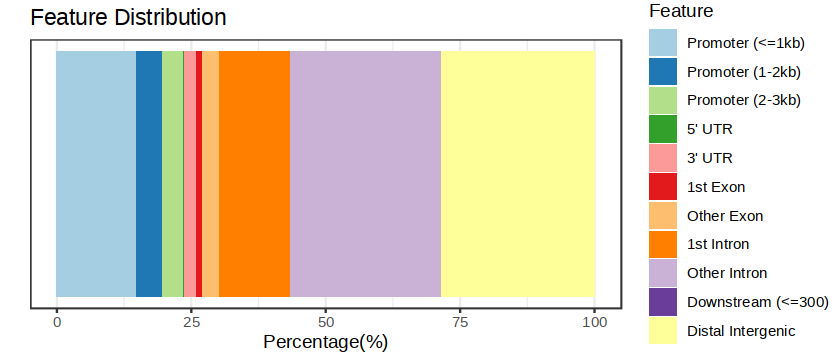

In [25]:
options(repr.plot.width = 7, repr.plot.height = 3)
plotAnnoBar(peaks_annot)

In [26]:
slotNames(peaks_annot)

[1] "anno"                    "tssRegion"              
[3] "level"                   "hasGenomicAnnotation"   
[5] "detailGenomicAnnotation" "annoStat"               
[7] "peakNum"

In [27]:
peaks_annot@anno

GRanges object with 334850 ranges and 12 metadata columns:
           seqnames            ranges strand |        annotation   geneChr
              <Rle>         <IRanges>  <Rle> |       <character> <integer>
       [1]     chr1       41457-41706      * | Distal Intergenic         1
       [2]     chr1       41844-42454      * | Distal Intergenic         1
       [3]     chr1       46484-46643      * | Distal Intergenic         1
       [4]     chr1       47458-47787      * | Distal Intergenic         1
       [5]     chr1       56157-56477      * | Distal Intergenic         1
       ...      ...               ...    ... .               ...       ...
  [334846]     chrY 24270821-24270977      * | Distal Intergenic        24
  [334847]     chrY 24271380-24271691      * | Distal Intergenic        24
  [334848]     chrY 24368003-24368602      * | Distal Intergenic        24
  [334849]     chrY 25301540-25302124      * | Distal Intergenic        24
  [334850]     chrY 25398454-25398765    

In [28]:
peaks_annot@anno$annotation_short = sapply(strsplit(peaks_annot@anno$annotation, " \\("), function(x) x[1])

In [29]:
table(peaks_annot@anno$annotation_short)


           3' UTR            5' UTR Distal Intergenic        Downstream 
             7453               721             95222               343 
             Exon            Intron          Promoter 
            14836            137725             78550 

In [30]:
peaks_annot@anno

GRanges object with 334850 ranges and 13 metadata columns:
           seqnames            ranges strand |        annotation   geneChr
              <Rle>         <IRanges>  <Rle> |       <character> <integer>
       [1]     chr1       41457-41706      * | Distal Intergenic         1
       [2]     chr1       41844-42454      * | Distal Intergenic         1
       [3]     chr1       46484-46643      * | Distal Intergenic         1
       [4]     chr1       47458-47787      * | Distal Intergenic         1
       [5]     chr1       56157-56477      * | Distal Intergenic         1
       ...      ...               ...    ... .               ...       ...
  [334846]     chrY 24270821-24270977      * | Distal Intergenic        24
  [334847]     chrY 24271380-24271691      * | Distal Intergenic        24
  [334848]     chrY 24368003-24368602      * | Distal Intergenic        24
  [334849]     chrY 25301540-25302124      * | Distal Intergenic        24
  [334850]     chrY 25398454-25398765    

In [31]:
peaks_annot@anno[which(peaks_annot@anno$SYMBOL == "CXCL5")]

GRanges object with 3 ranges and 13 metadata columns:
      seqnames            ranges strand |        annotation   geneChr geneStart
         <Rle>         <IRanges>  <Rle> |       <character> <integer> <integer>
  [1]     chr4 73998148-73999058      * |  Promoter (<=1kb)         4  73995642
  [2]     chr4 74016135-74016511      * | Distal Intergenic         4  73995642
  [3]     chr4 74017725-74018518      * | Distal Intergenic         4  73995642
        geneEnd geneLength geneStrand      geneId      transcriptId
      <integer>  <integer>  <integer> <character>       <character>
  [1]  73998677       3036          2        6374 ENST00000296027.5
  [2]  73998677       3036          2        6374 ENST00000296027.5
  [3]  73998677       3036          2        6374 ENST00000296027.5
      distanceToTSS         ENSEMBL      SYMBOL               GENENAME
          <numeric>     <character> <character>            <character>
  [1]             0 ENSG00000163735       CXCL5 C-X-C motif chem

In [32]:
peaks_annot@anno[which(peaks_annot@anno$SYMBOL %in% c("CXCL5", "PPBP", "PF4"))]

GRanges object with 12 ranges and 13 metadata columns:
       seqnames            ranges strand |             annotation   geneChr
          <Rle>         <IRanges>  <Rle> |            <character> <integer>
   [1]     chr4 73944061-73944901      * | Exon (ENST0000050280..         4
   [2]     chr4 73964988-73965369      * |      Distal Intergenic         4
   [3]     chr4 73968195-73968356      * |      Distal Intergenic         4
   [4]     chr4 73968463-73968670      * |      Distal Intergenic         4
   [5]     chr4 73975940-73976184      * |      Distal Intergenic         4
   ...      ...               ...    ... .                    ...       ...
   [8]     chr4 73981626-73982142      * |       Promoter (<=1kb)         4
   [9]     chr4 73984825-73985016      * |       Promoter (2-3kb)         4
  [10]     chr4 73998148-73999058      * |       Promoter (<=1kb)         4
  [11]     chr4 74016135-74016511      * |      Distal Intergenic         4
  [12]     chr4 74017725-74018518

In [33]:
overlap = findOverlaps(peaks_annot@anno, GRanges("chr4", IRanges(73978778, 74018779)))
overlap

Hits object with 6 hits and 0 metadata columns:
      queryHits subjectHits
      <integer>   <integer>
  [1]     83598           1
  [2]     83599           1
  [3]     83600           1
  [4]     83601           1
  [5]     83602           1
  [6]     83603           1
  -------
  queryLength: 334850 / subjectLength: 1

In [34]:
overlap = findOverlaps(peaks_annot@anno, GRanges("chr4", IRanges(73978778, 74018779)))

peaks_annot@anno[overlap@from]

GRanges object with 6 ranges and 13 metadata columns:
      seqnames            ranges strand |        annotation   geneChr geneStart
         <Rle>         <IRanges>  <Rle> |       <character> <integer> <integer>
  [1]     chr4 73978858-73979362      * |  Promoter (2-3kb)         4  73980811
  [2]     chr4 73981626-73982142      * |  Promoter (<=1kb)         4  73980811
  [3]     chr4 73984825-73985016      * |  Promoter (2-3kb)         4  73981074
  [4]     chr4 73998148-73999058      * |  Promoter (<=1kb)         4  73995642
  [5]     chr4 74016135-74016511      * | Distal Intergenic         4  73995642
  [6]     chr4 74017725-74018518      * | Distal Intergenic         4  73995642
        geneEnd geneLength geneStrand      geneId      transcriptId
      <integer>  <integer>  <integer> <character>       <character>
  [1]  73982027       1217          2        5196 ENST00000296029.4
  [2]  73982027       1217          2        5196 ENST00000296029.4
  [3]  73982027        954        

### Design matrix specification

In [35]:
y = asDGEList(working_windows)  # filtered regions

colnames(y$counts) = sample_ids
rownames(y$samples) = sample_ids

In [36]:
# Parse treatment groups from sample_ids
y$samples$group = sapply(strsplit(sample_ids, "-"), function(x) {
    return(x[length(x) - 1])
})

y$samples$group

[1] "Belinostat"    "Belinostat"    "Belinostat"    "Belinostat"   
 [5] "Belinostat"    "Belinostat"    "DMSO"          "DMSO"         
 [9] "DMSO"          "DMSO"          "DMSO"          "DMSO"         
[13] "unconditioned" "unconditioned" "unconditioned" "unconditioned"
[17] "unconditioned" "unconditioned"

In [37]:
# relabel experimental groups
y$samples$treatment = recode(y$samples$group, Belinostat="Belinostat+cytokine", DMSO="cytokine", unconditioned="control")

In [38]:
# Get design matrix for test
design = model.matrix(~0+group, data=y$samples)

In [39]:
design

,groupBelinostat,groupDMSO,groupunconditioned
conditioned-Belinostat-13_S7_L003_R1_001,1,0,0
conditioned-Belinostat-14_S8_L001_R1_001,1,0,0
conditioned-Belinostat-15_S9_L001_R1_001,1,0,0
conditioned-Belinostat-16_S10_L004_R1_001,1,0,0
conditioned-Belinostat-17_S11_L001_R1_001,1,0,0
conditioned-Belinostat-18_S12_L004_R1_001,1,0,0
conditioned-DMSO-19_S13_L004_R1_001,0,1,0
conditioned-DMSO-20_S14_L002_R1_001,0,1,0
conditioned-DMSO-21_S15_L002_R1_001,0,1,0
conditioned-DMSO-22_S16_L002_R1_001,0,1,0


### Negative binomial fit

In [40]:
# Wrapper function formatting genomic ranges table
formatResults = function(results, merged_peaks) {
    tab_best = getBestTest(merged_peaks$id, results$table)
    
    # concatenating all relevant statistical data for final merged windows (no redundant columns)
    tab = GRanges(cbind(as.data.frame(merged_peaks$region), results$table[tab_best$rep.test, -4], tab_best[,-c(7:8)]))

    # sort by FDR
    tab = tab[order(tab$FDR), ]
    
    return(tab)
}

In [41]:
FDR.thresh = 0.05

# Estimate dispersion
y = estimateDisp(y, design)

# fit negative binomial linear model with edgeR
fit = glmQLFit(y, design, robust=TRUE)

## PCA visualization

In [42]:
# Exploratory analysis of counts
y = calcNormFactors(y)
log_cpm = cpm(y, normalized.lib.sizes=TRUE, log=TRUE)  # adjusts for size factors

In [43]:
dim(log_cpm)

[1] 334850     18

In [44]:
# Principal component analysis
pca = prcomp(t(log_cpm), scale=TRUE)
summary(pca)

Importance of components:
                            PC1       PC2       PC3       PC4       PC5
Standard deviation     301.0850 172.33099 140.70286 132.45061 129.40304
Proportion of Variance   0.2707   0.08869   0.05912   0.05239   0.05001
Cumulative Proportion    0.2707   0.35942   0.41854   0.47093   0.52094
                             PC6       PC7       PC8       PC9     PC10
Standard deviation     127.22432 123.53851 121.22606 120.47927 116.8791
Proportion of Variance   0.04834   0.04558   0.04389   0.04335   0.0408
Cumulative Proportion    0.56928   0.61485   0.65874   0.70209   0.7429
                            PC11      PC12      PC13     PC14      PC15
Standard deviation     116.02969 113.93787 113.51767 112.9554 111.97702
Proportion of Variance   0.04021   0.03877   0.03848   0.0381   0.03745
Cumulative Proportion    0.78309   0.82186   0.86034   0.8984   0.93589
                            PC16      PC17      PC18
Standard deviation     106.49887 100.61773 1.178e-13
Prop

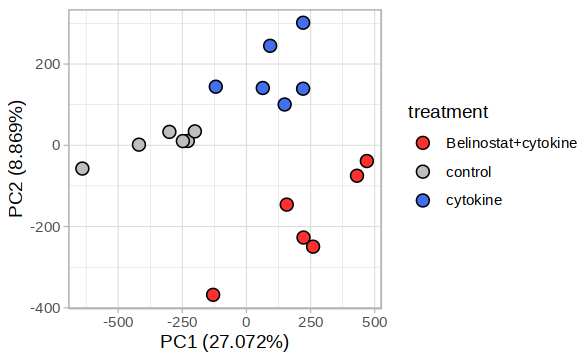

In [45]:
options(repr.plot.width=4.9, repr.plot.height=3)
ggplot(cbind(pca$x, y$samples), aes(x=PC1, y=PC2, fill=treatment, shape=group)) +
    geom_point(size=3, pch=21) +
    xlab(paste0("PC1 (", summary(pca)$importance[2, 1] * 100, "%)")) +
    ylab(paste0("PC2 (", summary(pca)$importance[2, 2] * 100, "%)")) +
    scale_fill_manual(values=c("firebrick1", "grey", "royalblue2")) +
    theme_light()

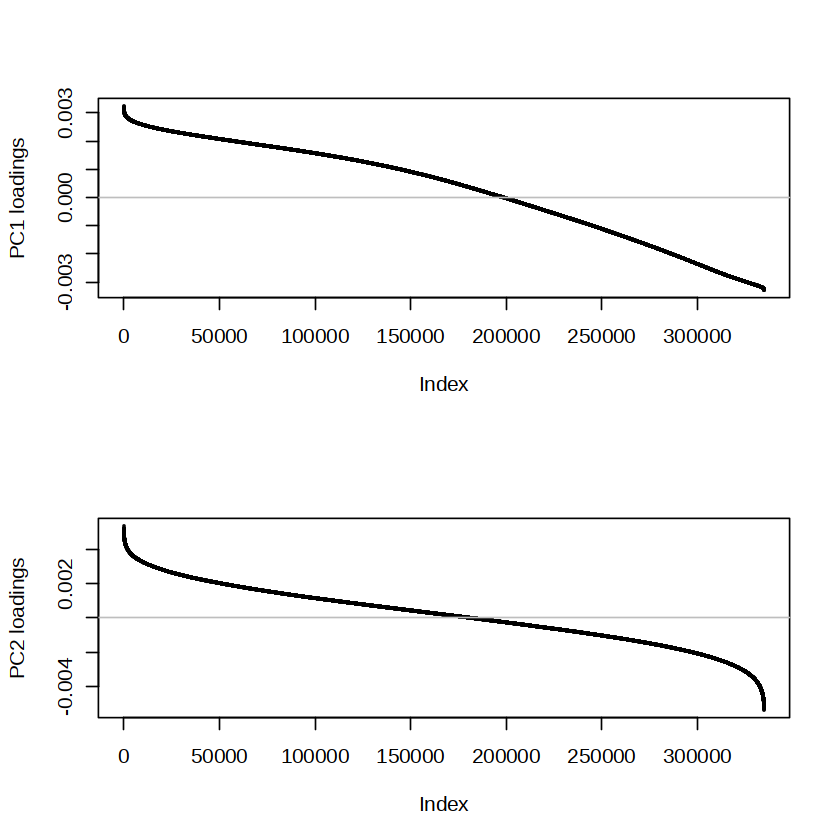

In [46]:
options(repr.plot.width=7, repr.plot.height=7)
par(mfrow=c(2, 1))
plot(sort(pca$rotation[, "PC1"], decreasing=TRUE), cex=0.1, ylab="PC1 loadings")
abline(h=0, col="grey")

plot(sort(pca$rotation[, "PC2"], decreasing=TRUE), cex=0.1, ylab="PC2 loadings")
abline(h=0, col="grey")

In [47]:
# Make table of PCA loadings per peak
peaks_loadings = peaks_annot

In [48]:
# Append 10 principal component loadings to table
peaks_loadings@anno@elementMetadata = cbind(peaks_loadings@anno@elementMetadata, pca$rotation[, 1:10])

In [49]:
#peaks_loadings

In [50]:
#write.csv(peaks_loadings@anno, "tables/peak_table_all_PCA_loadings.csv", row.names=FALSE)

In [51]:
saveRDS(peaks_loadings, "tables/peak_table_all_PCA_loadings.rds")

## PCA stratified by peak annotation

In [52]:
table(peaks_annot@anno$annotation_short)


           3' UTR            5' UTR Distal Intergenic        Downstream 
             7453               721             95222               343 
             Exon            Intron          Promoter 
            14836            137725             78550 

In [53]:
# assert that dimension of counts matrix and annotation table agrees
stopifnot(length(peaks_annot@anno) == (nrow(y)))


In [54]:
dim(y)

[1] 334850     18

In [55]:
# PCA and plot by
plt_list = lapply(names(sort(table(peaks_annot@anno$annotation_short), decreasing=TRUE)), function(annot) {
    idx = peaks_annot@anno$annotation_short == annot
    
    # Subset count matrix for particular annotation category
    y_sub = y[idx, ]
    print(dim(y_sub))
    
    # log normalized counts
    y_sub = calcNormFactors(y_sub)
    log_cpm_sub = cpm(y_sub, normalized.lib.sizes=TRUE, log=TRUE)  # adjusts for size factors

    # PCA
    pca = prcomp(t(log_cpm_sub), scale=TRUE)
    #print(summary(pca))
    
    pl = ggplot(cbind(pca$x, y_sub$samples), aes(x=PC1, y=PC2, fill=treatment, shape=group)) +
        geom_point(size=3, pch=21) +
        xlab(paste0("PC1 (", summary(pca)$importance[2, 1] * 100, "%)")) +
        ylab(paste0("PC2 (", summary(pca)$importance[2, 2] * 100, "%)")) +
        ggtitle(paste0(annot, " (", nrow(y_sub), " peaks)")) +
        scale_fill_manual(values=c("firebrick1", "grey", "royalblue2")) +
        theme_light()
    
    return(pl)
})

[1] 137725     18
[1] 95222    18
[1] 78550    18
[1] 14836    18
[1] 7453   18
[1] 721  18
[1] 343  18


In [56]:
#library(cowplot)

In [57]:
#options(repr.plot.width=8, repr.plot.height=8)
#cowplot::plot_grid(plot_list=plt_list)

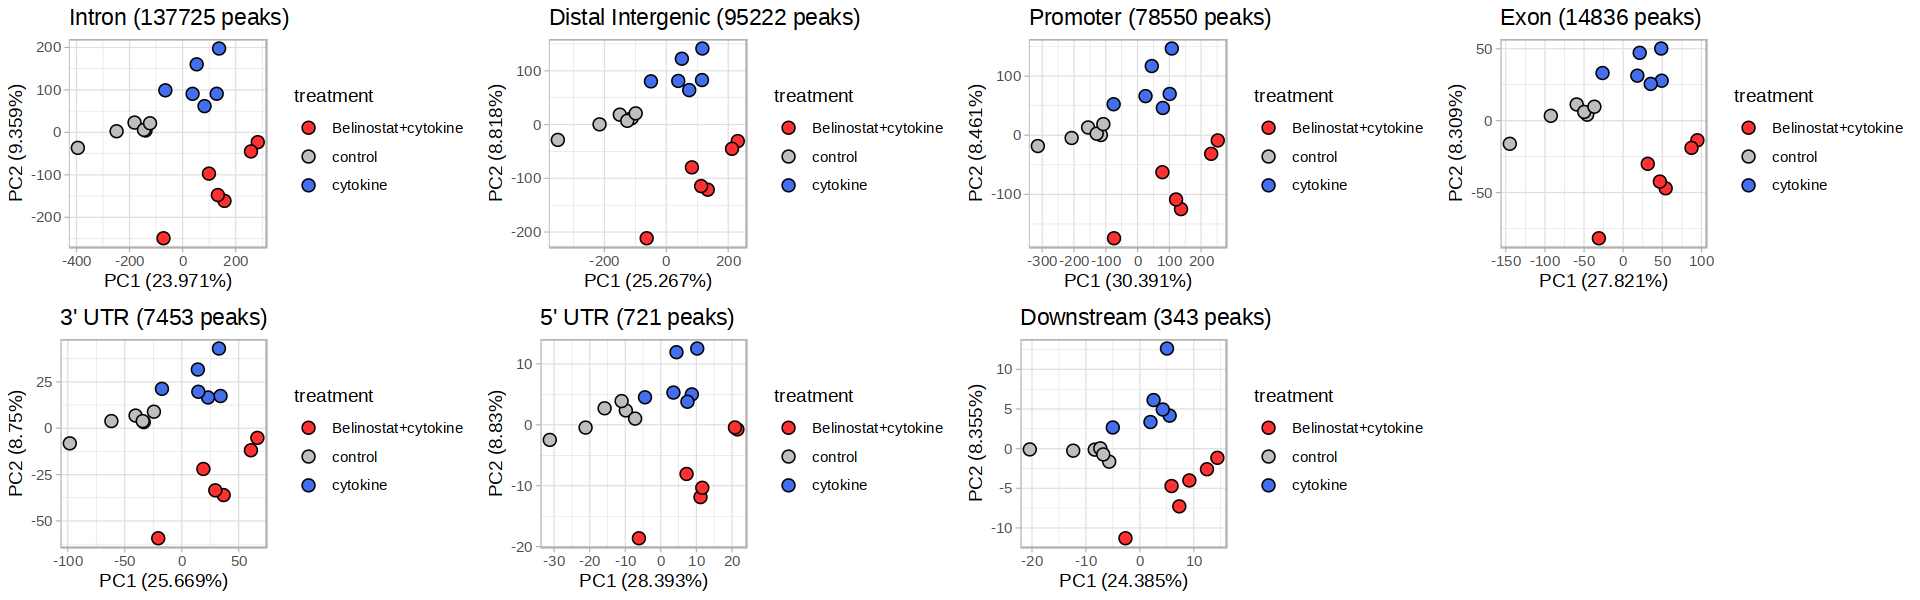

In [58]:
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=5)
ggarrange(plotlist=plt_list, ncol=4, nrow=2)

## Differential accessibility

In [59]:
tab_output_all = list()  # all
tab_output = list()  # significant filter
options(repr.matrix.max.cols=150)

In [60]:
# Generate tables of statistics for differentially-accessible windows

# Belinostat vs unconditioned
results = glmQLFTest(fit, contrast=makeContrasts(groupBelinostat-groupunconditioned, levels=design))
#condition_name = "Cytokine + Belinostat vs Unconditioned"
condition_name = "Cytokine + Belinostat" 

tab = formatResults(results, merged_peaks)
tab_output_all[[condition_name]] = annotatePeak(tab, TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb="org.Hs.eg.db")

# filter by FDR threshold
tab_sig = tab[tab$FDR < FDR.thresh, ]
#tab_sig

# Annotation with ChIPseeker
tab_sig = annotatePeak(tab_sig, TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb="org.Hs.eg.db")

tab_output[[condition_name]] = tab_sig  # store

tab_sig = as.data.frame(tab_sig)

head(tab_sig, 20)

>> preparing features information...		 2023-11-15 02:15:26 PM 
>> identifying nearest features...		 2023-11-15 02:15:26 PM 
>> calculating distance from peak to TSS...	 2023-11-15 02:15:30 PM 
>> assigning genomic annotation...		 2023-11-15 02:15:30 PM 
>> adding gene annotation...			 2023-11-15 02:15:39 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-11-15 02:15:40 PM 
>> done...					 2023-11-15 02:15:40 PM 
>> preparing features information...		 2023-11-15 02:15:40 PM 
>> identifying nearest features...		 2023-11-15 02:15:40 PM 
>> calculating distance from peak to TSS...	 2023-11-15 02:15:42 PM 
>> assigning genomic annotation...		 2023-11-15 02:15:42 PM 
>> adding gene annotation...			 2023-11-15 02:15:49 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-11-15 02:15:49 PM 
>> done...					 2023-11-15 02:15:49 PM 


,seqnames,start,end,width,strand,logFC,logCPM,F,num.tests,num.up.logFC,num.down.logFC,PValue,FDR,direction,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,chr11,126124171,126124869,699,*,-3.723276,1.86368236,160.9308,1,0,1,7.093529e-37,1.908471e-31,down,"Exon (ENST00000659151.1/105369591, exon 2 of 3)",11,126121889,126128081,6193,2,105369591,ENST00000659151.1,3212,NA,LOC105369591,uncharacterized LOC105369591
2,chr9,80797128,80798753,1626,*,-3.211815,1.79768215,131.8970,3,0,3,4.731732e-30,6.365221e-25,down,Distal Intergenic,9,80869758,80871295,1538,2,105376105,ENST00000397864.2,72542,NA,LOC105376105,uncharacterized LOC105376105
3,chr11,112655241,112656052,812,*,-3.118454,1.31645151,122.1620,1,0,1,2.129002e-28,1.909318e-23,down,"Intron (ENST00000691666.1/ENST00000691666.1, intron 2 of 4)",11,112698772,112721151,22380,2,105369496,ENST00000662440.1,65099,ENSG00000287006,LOC105369496,uncharacterized LOC105369496
4,chr9,65443,65969,527,*,-3.116927,1.25625289,120.1588,1,0,1,5.843705e-28,3.930535e-23,down,"Intron (ENST00000642633.1/100287171, intron 1 of 3)",9,72656,75329,2674,1,101929127,ENST00000442069.4,-6687,ENSG00000277631,PGM5P3-AS1,PGM5P3 antisense RNA 1
5,chr8,95996526,95997373,848,*,-3.033744,1.67887021,118.5322,1,0,1,1.326798e-27,7.139339e-23,down,Distal Intergenic,8,95947781,95948233,453,2,100500773,ENST00000523996.1,-48293,NA,SRSF3P2,SRSF3 pseudogene 2
6,chr8,124509934,124510660,727,*,-3.235975,0.82257620,117.6737,1,0,1,2.045676e-27,9.172947e-23,down,Promoter (1-2kb),8,124508515,124508576,62,2,102466200,ENST00000637122.1,-1358,ENSG00000284087,MIR6844,microRNA 6844
7,chr4,138727510,138728230,721,*,-2.904985,2.33044207,117.1417,1,0,1,2.674644e-27,1.027996e-22,down,Distal Intergenic,4,138819954,138821465,1512,2,105377448,ENST00000505607.1,93235,ENSG00000250195,LOC105377448,uncharacterized LOC105377448
8,chr1,175223806,175224344,539,*,-3.122903,0.77645949,114.4878,1,0,1,1.019572e-26,3.428870e-22,down,Distal Intergenic,1,175161044,175192999,31956,2,9674,ENST00000563563.2,-30807,ENSG00000235750,KIAA0040,KIAA0040
9,chr1,48035361,48035738,378,*,-2.992279,1.52630048,111.3046,1,0,1,5.077560e-26,1.517874e-21,down,Distal Intergenic,1,48050659,48091736,41078,1,105379778,ENST00000635446.1,-14921,NA,LINC02794,long intergenic non-protein coding RNA 2794



           3' UTR            5' UTR Distal Intergenic        Downstream 
             2038               257             23440               104 
             Exon            Intron          Promoter 
             3924             37736             29269 

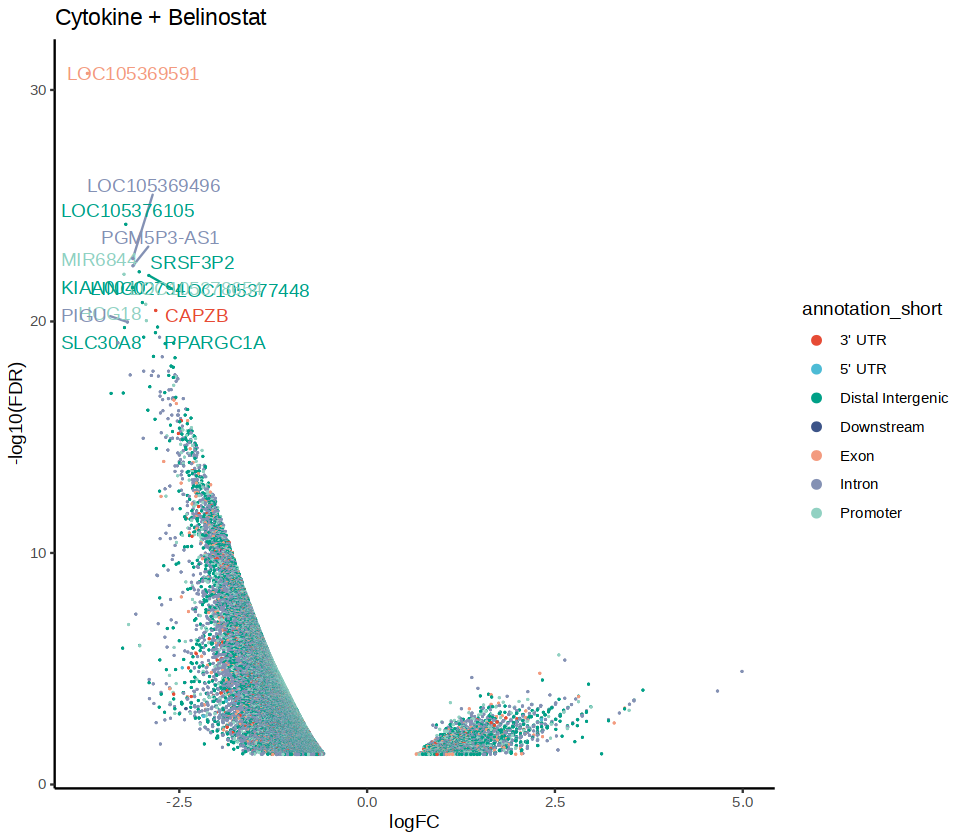

In [61]:
# Volcano plots
width = 8; height = 7;
options(repr.plot.width = width, repr.plot.height = height)

tab_sig$annotation_short = sapply(strsplit(tab_sig$annotation, " \\("), function(x) x[1])
table(tab_sig$annotation_short)

top_n = 15  # label
tab_sig$symbol_show = ""
tab_sig$symbol_show[1:top_n] = tab_sig$SYMBOL[1:top_n]

ggplot(as.data.frame(tab_sig), aes(x=logFC, y=-log10(FDR), label=symbol_show, color=annotation_short)) +
    ggtitle(condition_name) +
    geom_text_repel(max.overlaps=15, show.legend=FALSE) +
    geom_point_rast(size=0.1) +
    scale_color_npg() +  # Nature Publishing Group colors
    theme_classic() +
    guides(colour = guide_legend(override.aes = list(size=2)))
                                  
ggsave("plots/peak_volcano_belinostat_unconditioned.pdf", width=width, height=height)

In [62]:
# Belinostat vs DMSO
results = glmQLFTest(fit, contrast=makeContrasts(groupBelinostat-groupDMSO, levels=design))
#condition_name = "Cytokine + Belinostat vs Cytokine + DMSO"
condition_name = "Belinostat | cytokine" 


tab = formatResults(results, merged_peaks)
tab_output_all[[condition_name]] = annotatePeak(tab, TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb="org.Hs.eg.db")

# filter by FDR threshold
tab_sig = tab[tab$FDR < FDR.thresh, ]
tab_sig

# Annotation with ChIPseeker
tab_sig = annotatePeak(tab_sig, TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb="org.Hs.eg.db")

tab_output[[condition_name]] = tab_sig  # store

tab_sig = as.data.frame(tab_sig)

head(tab_sig, 20)


>> preparing features information...		 2023-11-15 02:16:05 PM 
>> identifying nearest features...		 2023-11-15 02:16:05 PM 
>> calculating distance from peak to TSS...	 2023-11-15 02:16:09 PM 
>> assigning genomic annotation...		 2023-11-15 02:16:09 PM 
>> adding gene annotation...			 2023-11-15 02:16:17 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-11-15 02:16:18 PM 
>> done...					 2023-11-15 02:16:18 PM 


GRanges object with 2129 ranges and 9 metadata columns:
         seqnames              ranges strand |     logFC     logCPM         F
            <Rle>           <IRanges>  <Rle> | <numeric>  <numeric> <numeric>
  206617    chr11 126124171-126124869      * |  -2.60135   1.863682   77.8621
  206709    chr11 126459555-126460178      * |  -2.15200   2.139047   63.5731
  185231    chr10   98357547-98357748      * |  -2.72675  -0.103825   53.7591
   10723     chr1   48035361-48035738      * |  -2.01273   1.526300   49.6326
  161095     chr9   27413620-27414832      * |  -2.02144   1.086582   47.5039
     ...      ...                 ...    ... .       ...        ...       ...
   21281     chr1 168503999-168504723      * | -0.882811  2.4397097   12.5590
   27473     chr1 224245185-224245699      * | -1.027206 -0.0168883   12.5572
   28959     chr1 232902122-232902670      * | -0.972632  0.6506020   12.5557
  189009    chr10 124296118-124296721      * | -0.972945  0.6385621   12.5555
  279984

>> preparing features information...		 2023-11-15 02:16:18 PM 
>> identifying nearest features...		 2023-11-15 02:16:18 PM 
>> calculating distance from peak to TSS...	 2023-11-15 02:16:19 PM 
>> assigning genomic annotation...		 2023-11-15 02:16:19 PM 
>> adding gene annotation...			 2023-11-15 02:16:26 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-11-15 02:16:27 PM 
>> done...					 2023-11-15 02:16:27 PM 


,seqnames,start,end,width,strand,logFC,logCPM,F,num.tests,num.up.logFC,num.down.logFC,PValue,FDR,direction,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,chr11,126124171,126124869,699,*,-2.601348,1.86368236,77.86212,1,0,1,1.105244e-18,2.973592e-13,down,"Exon (ENST00000659151.1/105369591, exon 2 of 3)",11,126121889,126128081,6193,2,105369591,ENST00000659151.1,3212,NA,LOC105369591,uncharacterized LOC105369591
2,chr11,126459555,126460178,624,*,-2.152003,2.13904718,63.57307,1,0,1,1.545594e-15,2.079163e-10,down,"Intron (ENST00000525144.7/84623, intron 6 of 16)",11,126429179,126440882,11704,2,84623,ENST00000532647.1,-18673,ENSG00000149571,KIRREL3,kirre like nephrin family adhesion molecule 3
3,chr10,98357547,98357748,202,*,-2.726749,-0.10382523,53.75912,1,0,1,2.266730e-13,2.032834e-08,down,Distal Intergenic,10,98387201,98388436,1236,2,84795,ENST00000464808.1,30688,ENSG00000119943,PYROXD2,pyridine nucleotide-disulphide oxidoreductase domain 2
4,chr1,48035361,48035738,378,*,-2.012729,1.52630048,49.63264,1,0,1,1.854270e-12,1.247201e-07,down,Distal Intergenic,1,48050659,48091736,41078,1,105379778,ENST00000635446.1,-14921,NA,LINC02794,long intergenic non-protein coding RNA 2794
5,chr9,27413620,27414832,1213,*,-2.021436,1.08658224,47.50386,2,0,1,1.098045e-11,5.908451e-07,down,"Intron (ENST00000262244.6/79817, intron 2 of 3)",9,27359024,27421714,62691,2,79817,ENST00000603061.1,6882,ENSG00000120162,MOB3B,MOB kinase activator 3B
6,chr14,95206470,95206950,481,*,-2.094064,0.11275267,44.99485,1,0,1,1.975737e-11,8.859338e-07,down,"Intron (ENST00000298912.9/79789, intron 8 of 12)",14,95191530,95210851,19322,2,79789,ENST00000556454.1,3901,ENSG00000165959,CLMN,calmin
7,chrX,66622184,66622773,590,*,-2.009698,0.64146411,44.51155,1,0,1,2.528867e-11,9.719664e-07,down,"Intron (ENST00000374719.8/60401, intron 1 of 6)",23,66595642,66616030,20389,2,60401,ENST00000396050.5,-6154,ENSG00000131080,EDA2R,ectodysplasin A2 receptor
8,chr1,164155270,164155851,582,*,-1.739592,1.98847543,43.92222,1,0,1,3.417219e-11,1.149228e-06,down,Distal Intergenic,1,164555584,164564015,8432,1,5087,ENST00000467023.5,-399733,ENSG00000185630,PBX1,PBX homeobox 1
9,chr10,75081858,75082346,489,*,-1.863325,0.81304111,43.25582,1,0,1,4.803537e-11,1.435959e-06,down,Distal Intergenic,10,75037472,75073642,36171,2,338599,ENST00000338487.6,-8216,ENSG00000188716,DUSP29,dual specificity phosphatase 29



           3' UTR            5' UTR Distal Intergenic        Downstream 
               36                 5               674                 3 
             Exon            Intron          Promoter 
               94               983               334 

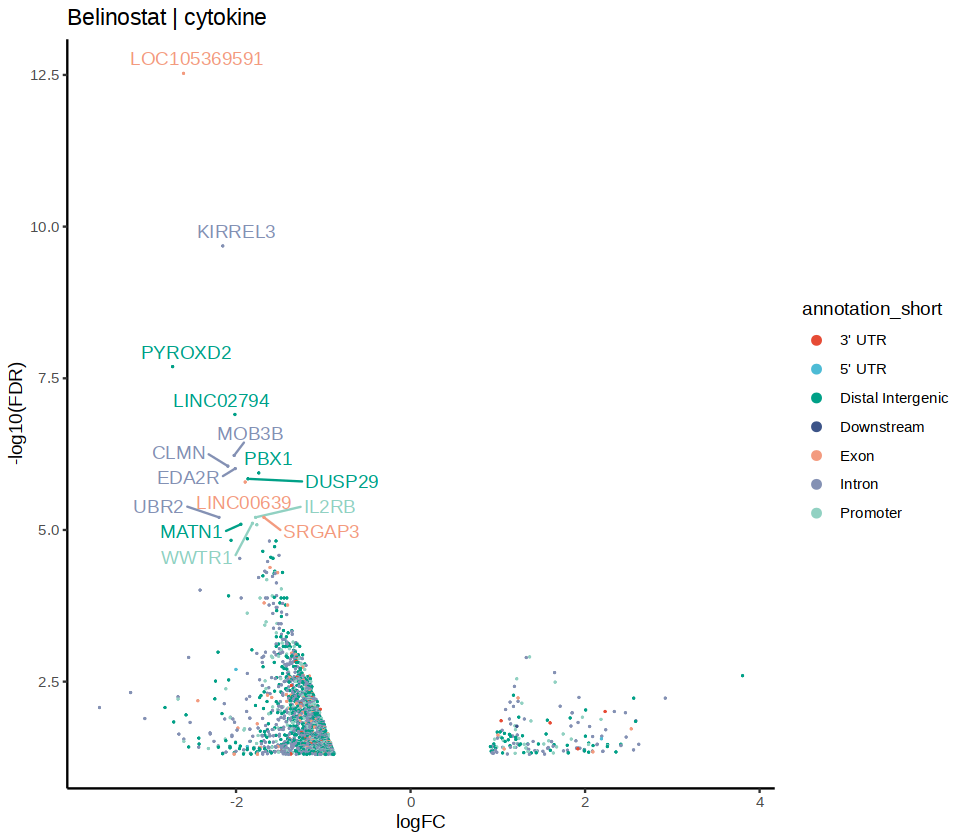

In [63]:
# Volcano plots
width=8; height=7;
options(repr.plot.width = width, repr.plot.height = height)

tab_sig$annotation_short = sapply(strsplit(tab_sig$annotation, " \\("), function(x) x[1])
table(tab_sig$annotation_short)
                                  
top_n = 15  # label
tab_sig$symbol_show = ""
tab_sig$symbol_show[1:top_n] = tab_sig$SYMBOL[1:top_n]

ggplot(as.data.frame(tab_sig), aes(x=logFC, y=-log10(FDR), label=symbol_show, color=annotation_short)) +
    ggtitle(condition_name) +
    geom_text_repel(max.overlaps=15, show.legend=FALSE) +
    geom_point_rast(size=0.1) +
    scale_color_npg() +  # Nature Publishing Group colors
    theme_classic() +
    guides(colour = guide_legend(override.aes = list(size=2)))
                                  
ggsave("plots/peak_volcano_belinostat_DMSO.pdf", width=width, height=height)

In [64]:
# DMSO vs unconditioned
results = glmQLFTest(fit, contrast=makeContrasts(groupDMSO-groupunconditioned, levels=design))
#condition_name = "Cytokine + DMSO vs Unconditioned"
condition_name = "Cytokine"

tab = formatResults(results, merged_peaks)
tab_output_all[[condition_name]] = annotatePeak(tab, TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb="org.Hs.eg.db")

# filter by FDR threshold
tab_sig = tab[tab$FDR < FDR.thresh, ]
tab_sig

# Annotation with ChIPseeker
tab_sig = annotatePeak(tab_sig, TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb="org.Hs.eg.db")

tab_output[[condition_name]] = tab_sig  # store

tab_sig = as.data.frame(tab_sig)

head(tab_sig, 20)

>> preparing features information...		 2023-11-15 02:16:33 PM 
>> identifying nearest features...		 2023-11-15 02:16:33 PM 
>> calculating distance from peak to TSS...	 2023-11-15 02:16:37 PM 
>> assigning genomic annotation...		 2023-11-15 02:16:37 PM 
>> adding gene annotation...			 2023-11-15 02:16:46 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-11-15 02:16:47 PM 
>> done...					 2023-11-15 02:16:47 PM 


GRanges object with 77168 ranges and 9 metadata columns:
         seqnames              ranges strand |     logFC    logCPM         F
            <Rle>           <IRanges>  <Rle> | <numeric> <numeric> <numeric>
   71734     chr3 137263985-137264890      * |  -2.07750  1.176710   66.1370
  150750     chr8   59769017-59769589      * |  -2.38018 -0.222411   65.5732
  159511     chr9     2424493-2425219      * |  -2.11561  1.418574   68.1285
  272384    chr17   33766447-33767231      * |  -2.09441  1.145076   66.6432
  306150    chr20   34605018-34605418      * |  -2.13832  0.185346   63.7640
     ...      ...                 ...    ... .       ...       ...       ...
  213053    chr12   49966924-49967864      * | -0.592977  2.268961   5.99635
  294246    chr19   18607290-18607752      * | -0.712147 -0.392608   5.99634
  179273    chr10   48154748-48156168      * |  0.977047 -0.797070   7.96125
  245857    chr15   52046655-52046884      * | -0.948882 -1.447332   5.99584
  152791     chr8  

>> preparing features information...		 2023-11-15 02:16:47 PM 
>> identifying nearest features...		 2023-11-15 02:16:47 PM 
>> calculating distance from peak to TSS...	 2023-11-15 02:16:49 PM 
>> assigning genomic annotation...		 2023-11-15 02:16:49 PM 
>> adding gene annotation...			 2023-11-15 02:16:55 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-11-15 02:16:55 PM 
>> done...					 2023-11-15 02:16:55 PM 


,seqnames,start,end,width,strand,logFC,logCPM,F,num.tests,num.up.logFC,num.down.logFC,PValue,FDR,direction,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,chr3,137263985,137264890,906,*,-2.077498,1.17670980,66.13701,1,0,1,4.207365e-16,3.767183e-11,down,Distal Intergenic,3,136959125,136982196,23072,2,107986136,ENST00000462176.2,-281789,NA,IL20RB-AS1,IL20RB antisense RNA 1
2,chr8,59769017,59769589,573,*,-2.380182,-0.22241099,65.57316,1,0,1,5.600843e-16,3.767183e-11,down,Distal Intergenic,8,59561327,59604774,43448,2,105375860,ENST00000521456.2,-164243,NA,LOC105375860,uncharacterized LOC105375860
3,chr9,2424493,2425219,727,*,-2.115605,1.41857375,68.12855,1,0,1,1.532132e-16,3.767183e-11,down,Promoter (<=1kb),9,2421926,2425957,4032,2,101930053,ENST00000653709.1,738,NA,LOC101930053,uncharacterized LOC101930053
4,chr17,33766447,33767231,785,*,-2.094413,1.14507636,66.64319,1,0,1,3.254523e-16,3.767183e-11,down,"Intron (ENST00000359872.6/40, intron 1 of 9)",17,33580076,33624122,44047,1,147004,ENST00000579975.1,186371,NA,LOC147004,uncharacterized LOC147004
5,chr20,34605018,34605418,401,*,-2.138318,0.18534582,63.76404,1,0,1,1.402817e-15,7.548392e-11,down,"Intron (ENST00000217446.8/128869, intron 7 of 11)",20,34560903,34616093,55191,2,128869,ENST00000438215.1,10675,ENSG00000101464,PIGU,phosphatidylinositol glycan anchor biosynthesis class U
6,chr18,13606415,13607253,839,*,-2.038923,1.37411105,62.83286,1,0,1,2.250591e-15,1.009180e-10,down,"Intron (ENST00000679177.1/753, intron 3 of 5)",18,13611114,13611200,87,1,100616130,ENST00000583168.1,-3861,ENSG00000263527,MIR4526,microRNA 4526
7,chr2,32882931,32883751,821,*,-1.974656,1.73885376,61.12432,1,0,1,5.359241e-15,2.059817e-10,down,Promoter (<=1kb),2,32882801,32926522,43722,1,285045,ENST00000435075.1,130,ENSG00000230876,LINC00486,long intergenic non-protein coding RNA 486
8,chr1,81440818,81441170,353,*,3.201871,-0.76256659,59.33378,1,1,0,1.330966e-14,4.476106e-10,up,"Intron (ENST00000674378.1/23266, intron 2 of 5)",1,81414275,81484722,70448,1,23266,ENST00000674458.1,26543,ENSG00000117114,ADGRL2,adhesion G protein-coupled receptor L2
9,chr11,100459811,100460181,371,*,-2.184538,-0.22497072,57.99895,1,0,1,2.623025e-14,7.841212e-10,down,Distal Intergenic,11,100687288,100993941,306654,1,143872,ENST00000298815.13,-227107,ENSG00000165895,ARHGAP42,Rho GTPase activating protein 42



           3' UTR            5' UTR Distal Intergenic        Downstream 
             1640               182             17877                75 
             Exon            Intron          Promoter 
             3103             29070             25221 

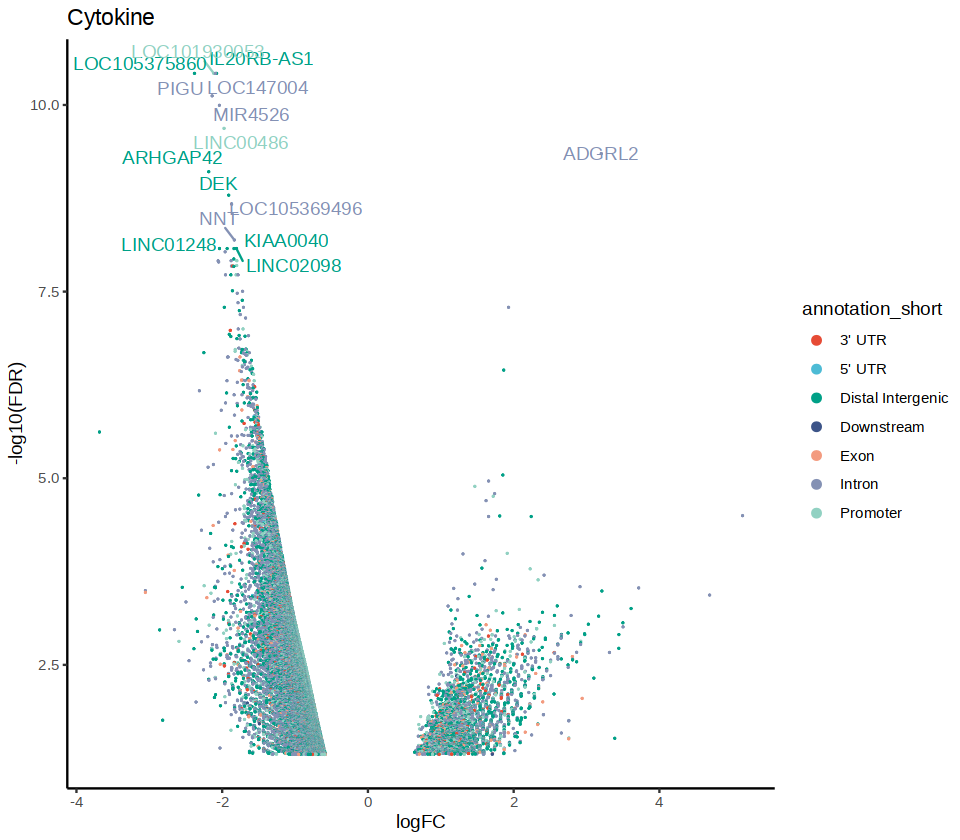

In [65]:
# Volcano plots
width = 8; height = 7;
options(repr.plot.width = width, repr.plot.height = height)

tab_sig$annotation_short = sapply(strsplit(tab_sig$annotation, " \\("), function(x) x[1])
table(tab_sig$annotation_short)
                                  
top_n = 15  # label
tab_sig$symbol_show = ""
tab_sig$symbol_show[1:top_n] = tab_sig$SYMBOL[1:top_n]

ggplot(as.data.frame(tab_sig), aes(x=logFC, y=-log10(FDR), label=symbol_show, color=annotation_short)) +
    ggtitle(condition_name) +
    geom_text_repel(max.overlaps=15, show.legend=FALSE) +
    geom_point_rast(size=0.1) +
    scale_color_npg() +  # Nature Publishing Group colors
    theme_classic() +
    guides(colour = guide_legend(override.aes = list(size=2)))
                                  
ggsave("plots/peak_volcano_DMSO_unconditioned.pdf", width=width, height=height)

cairo_pdf 
        3

png 
  2

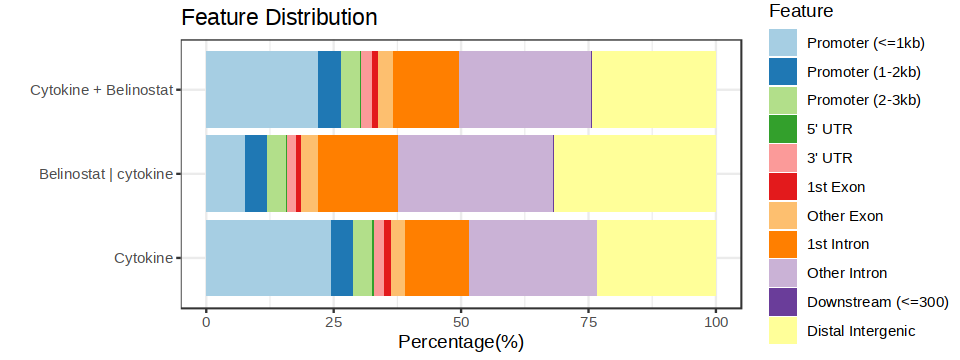

In [66]:
# Barplot of annotation categories by comparison
options(repr.plot.width = 8, repr.plot.height = 3)
par(mar=c(6, 2, 2, 2))
plotAnnoBar(tab_output)

dev.copy(grDevices::cairo_pdf, "plots/differential_peaks_FDR05_annotation_barplot.pdf", width=8, height=3)  # Cairo works better with unicode characters
dev.off()


cairo_pdf 
        3

png 
  2

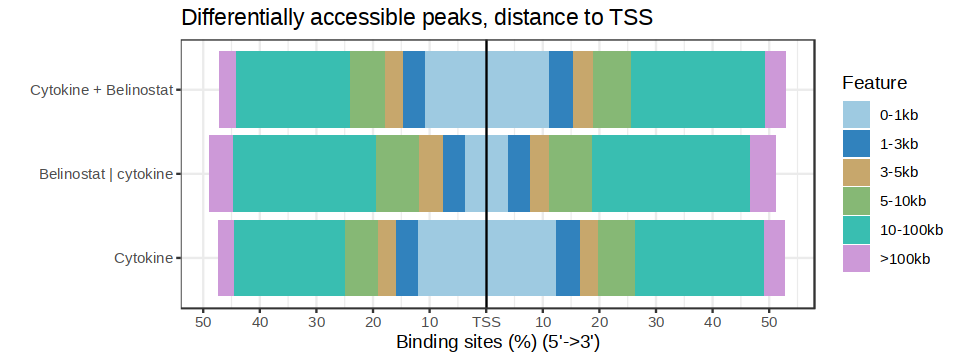

In [67]:
options(repr.plot.width = 8, repr.plot.height = 3)
plotDistToTSS(tab_output, title="Differentially accessible peaks, distance to TSS")

dev.copy(grDevices::cairo_pdf, "plots/differential_peaks_FDR05_TSSdist_barplot.pdf", width=8, height=3)  # Cairo works better with unicode characters
dev.off()

In [68]:
# Store annotated differential peak tables
saveRDS(tab_output, "tables/differential_peak_tables_FDR05_annotated.rds")

In [69]:
names(tab_output_all)

[1] "Cytokine + Belinostat" "Belinostat | cytokine" "Cytokine"

In [70]:
tab_output_all

$`Cytokine + Belinostat`
Annotated peaks generated by ChIPseeker
269044/269044  peaks were annotated
Genomic Annotation Summary:
              Feature  Frequency
9    Promoter (<=1kb) 13.8337967
10   Promoter (1-2kb)  4.5252821
11   Promoter (2-3kb)  3.8317153
4              5' UTR  0.2664992
3              3' UTR  2.3367925
1            1st Exon  1.2871501
7          Other Exon  3.5076047
2          1st Intron 13.2963381
8        Other Intron 28.1719719
6  Downstream (<=300)  0.1007270
5   Distal Intergenic 28.8421225

$`Belinostat | cytokine`
Annotated peaks generated by ChIPseeker
269044/269044  peaks were annotated
Genomic Annotation Summary:
              Feature  Frequency
9    Promoter (<=1kb) 13.8337967
10   Promoter (1-2kb)  4.5252821
11   Promoter (2-3kb)  3.8317153
4              5' UTR  0.2664992
3              3' UTR  2.3367925
1            1st Exon  1.2871501
7          Other Exon  3.5076047
2          1st Intron 13.2963381
8        Other Intron 28.1719719
6  Downstream (

## Compare differential peaks across conditions

In [71]:
# scatter helper function
scatterDensity = function(i, j, tab_output_all) {
    # match peaks of jth table with ith.
    idx = match(tab_output_all[[i]]@anno, tab_output_all[[j]]@anno)

    ggplot(data.frame(x=tab_output_all[[i]]@anno$logFC, y=tab_output_all[[j]]@anno[idx]$logFC), aes(x=x, y=y)) +
        geom_point_rast(alpha=1.0, size=0.05) +
        geom_density_2d_filled(alpha=0.7) +
        geom_density2d(color="white", linewidth=0.1) +
        scale_fill_viridis_d(option="rocket", direction=-1) +  # reverse magma colors
        xlab(paste0("logFC (", names(tab_output_all)[i], ")")) +
        ylab(paste0("logFC (", names(tab_output_all)[j], ")")) +
        stat_cor(method="pearson") +  # plot correlation statistics
        theme_bw()
}

# Prepare plots
plts = list()
plts[[1]] = scatterDensity(i=2, j=3, tab_output_all)
plts[[2]] = scatterDensity(i=1, j=2, tab_output_all)
plts[[3]] = scatterDensity(i=1, j=3, tab_output_all)

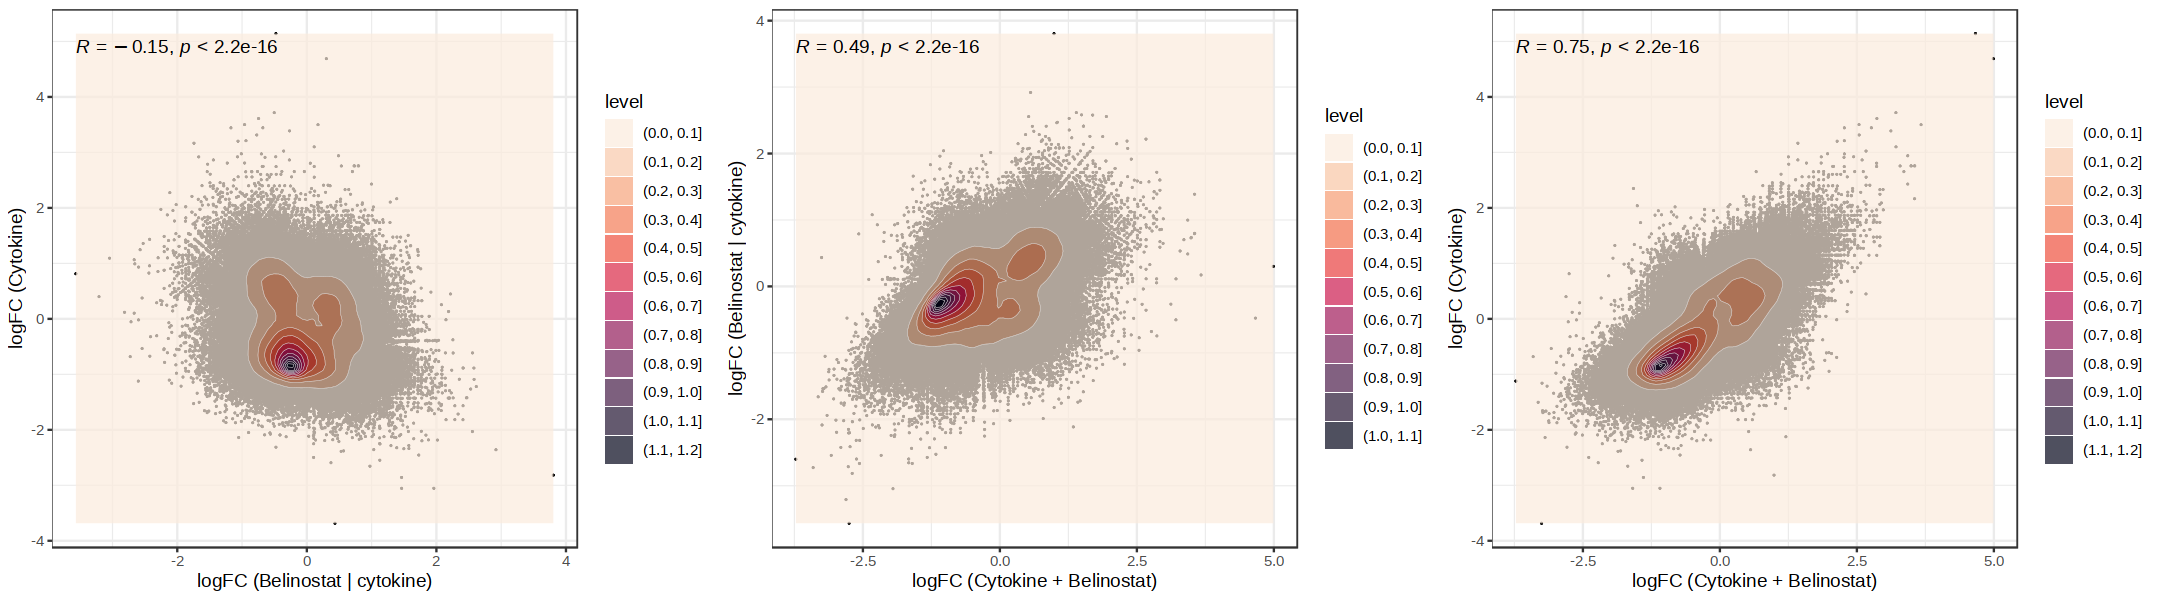

In [72]:
# Render plots as array
width = 18; height = 5;
options(repr.plot.width = width, repr.plot.height = height)

ggarrange(plotlist=plts, ncol=3)
ggsave("plots/peak_fold_change_comparison.pdf", width=width, height=height)

## High-confidence recurrent peaks

In [73]:
names(tab_output_all)

[1] "Cytokine + Belinostat" "Belinostat | cytokine" "Cytokine"

In [74]:
slotNames(tab_output_all[[1]])

[1] "anno"                    "tssRegion"              
[3] "level"                   "hasGenomicAnnotation"   
[5] "detailGenomicAnnotation" "annoStat"               
[7] "peakNum"

In [75]:
#tab_output_all[[1]]@anno

In [76]:
tab_output_all[[2]]@anno

GRanges object with 269044 ranges and 21 metadata columns:
         seqnames              ranges strand |       logFC    logCPM
            <Rle>           <IRanges>  <Rle> |   <numeric> <numeric>
  206617    chr11 126124171-126124869      * |    -2.60135  1.863682
  206709    chr11 126459555-126460178      * |    -2.15200  2.139047
  185231    chr10   98357547-98357748      * |    -2.72675 -0.103825
   10723     chr1   48035361-48035738      * |    -2.01273  1.526300
  161095     chr9   27413620-27414832      * |    -2.02144  1.086582
     ...      ...                 ...    ... .         ...       ...
  334798     chrX 156012545-156013905      * |  0.23578919 -1.786448
  334825     chrY   10986697-10989216      * | -0.28896935 -0.890095
  334837     chrY   11030107-11030258      * | -0.02641422 -1.812012
  334840     chrY   11037077-11037227      * |  0.00385169 -2.340550
  334841     chrY   11098529-11098842      * |  0.00247386 -1.342983
                   F num.tests num.up.logFC 

In [77]:
# Gene set enrichment analysis of gene annotations

In [120]:
# Filter peaks with more stringent differential accessibility statistics
tab_output_filter = lapply(tab_output, function(tab) {
    tab = as.data.frame(tab)
    #tab = tab[tab$FDR < 0.01 & abs(tab$logFC) > 2, ]
    tab = tab[tab$FDR < 0.01 & abs(tab$logFC) > 1, ]
    #tab = tab[tab$FDR < 0.01, ]
    return(tab)
})
lapply(tab_output_filter, dim)

$`Cytokine + Belinostat`
[1] 53712    26

$`Belinostat | cytokine`
[1] 618  26

$Cytokine
[1] 18713    26

In [131]:
gene_sets = lapply(tab_output_filter, function(tab) {
    return(unique(tab$SYMBOL))
})

In [130]:
# # Get gene sets
# gene_sets = lapply(tab_output_filter, function(tab) {
#     #unique(tab$SYMBOL)
#     counts = table(tab$SYMBOL)
#     return(names(which(counts >=1)))  # at least 1
# })
# lapply(gene_sets, length)

$`Cytokine + Belinostat`
[1] 18279

$`Belinostat | cytokine`
[1] 589

$Cytokine
[1] 9075

cairo_pdf 
        3

png 
  2

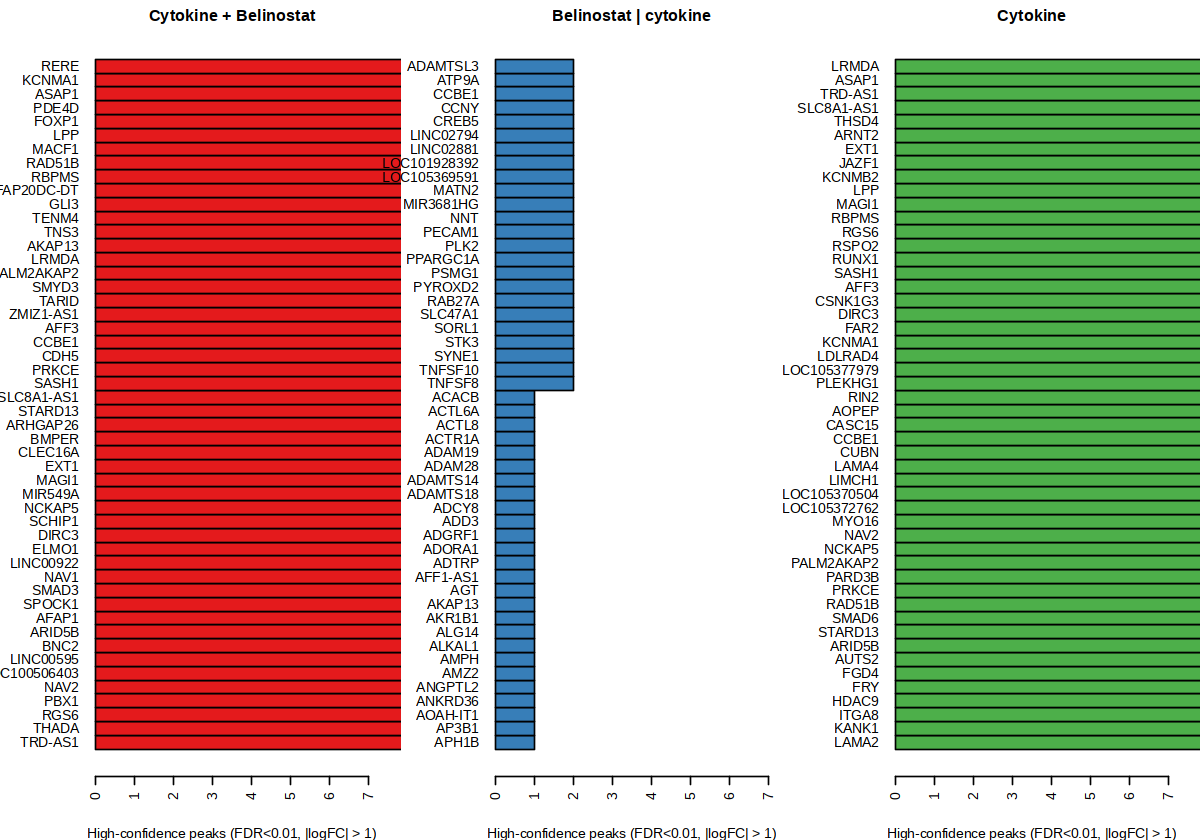

In [116]:
# Recurrently identified genes from high-confidence peaks
par(mfrow=c(1, 3))
width = 10; height=7;
options(repr.plot.width = width, repr.plot.height = height)
par(mar=c(4, 6, 2, 2))

colors = brewer.pal(9, "Set1")
names(colors) = names(tab_output_filter)
for (name in names(tab_output_filter)) {
    tab_sig = tab_output_filter[[name]]
    barplot(
        rev(head(sort(table(tab_sig$SYMBOL), decreasing=T), 50)),
        las=2,
        horiz = T,
        xlim=c(0, 7),
        xlab="High-confidence peaks (FDR<0.01, |logFC| > 1)",
        col=colors[[name]],
        space=0,  # no space between bars
        main=name)
}

dev.copy(grDevices::cairo_pdf, "plots/recurrent_differentially_accessible_peaks.pdf", width=width, height=height)  # Cairo works better with unicode characters
dev.off()

In [127]:
results = gost(gene_sets[[2]])
results$result

query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
query_1,TRUE,9.393958e-15,3068,373,120,0.3217158,0.03911343,GO:0048513,GO:BP,animal organ development,21010,13448,GO:0048856
query_1,TRUE,2.787096e-12,3951,373,135,0.3619303,0.03416856,GO:0048731,GO:BP,system development,21010,13640,GO:00072....
query_1,TRUE,1.519919e-10,4610,373,145,0.3887399,0.03145336,GO:0007275,GO:BP,multicellular organism development,21010,2853,GO:00325....
query_1,TRUE,3.866873e-10,6414,373,181,0.4852547,0.02821952,GO:0032502,GO:BP,developmental process,21010,7976,GO:0008150
query_1,TRUE,1.807680e-09,5862,373,168,0.4504021,0.02865916,GO:0048856,GO:BP,anatomical structure development,21010,13752,GO:0032502
query_1,TRUE,2.469537e-09,2683,373,98,0.2627346,0.03652628,GO:0009653,GO:BP,anatomical structure morphogenesis,21010,3628,GO:00325....
query_1,TRUE,1.284875e-08,6495,373,178,0.4772118,0.02740570,GO:0007154,GO:BP,cell communication,21010,2765,GO:0009987
query_1,TRUE,1.336841e-08,6396,373,176,0.4718499,0.02751720,GO:0023052,GO:BP,signaling,21010,6955,GO:0050789
query_1,TRUE,1.819596e-08,2004,373,79,0.2117962,0.03942116,GO:0009888,GO:BP,tissue development,21010,3806,GO:0048856


In [128]:
names(gene_sets)

[1] "Cytokine + Belinostat" "Belinostat | cytokine" "Cytokine"

In [129]:
writeLines(gene_sets[[2]])

LOC105369591
KIRREL3
PYROXD2
LINC02794
MOB3B
CLMN
EDA2R
PBX1
DUSP29
LINC00639
SRGAP3
UBR2
IL2RB
WWTR1
MATN1
TTC39C
LINC02881
PLK2
BNC2
SPHK1
LOC105379377
SRSF3P2
LOC105378502
TUT7
LOC101927389
PSMG1
SNCAIP
KALRN
SLC2A9
LOC105377448
ECT2L
JAZF1-AS1
LOC729815
PIGT
MYO3B
TFAM
PECAM1
LINC02653
SYN3
TNFSF10
CCL11
RIBC2
SORL1
ADAMTS18
LOC101928392
EDEM2
MOGAT1
LOC101929230
CSGALNACT1
LINC02099
LINC02964
ERMP1
FAM13C
LINC00400
LOC100129066
PLA2G5
KCNK12
RNASEL
DCP1B
LINC00656
MATN2
TBX2-AS1
GJE1
CFAP95
AKR1B1
NMT2
ACACB
CCDC171
ZAP70
NA
PLCB1
LOC105372522
ATP5MG
ACTR1A
CREB1
LINC02656
NRP1
LINC01509
HCG18
TCF7L2
CYP2A6
PSMG4
CYP26B1
PPARGC1A
LOC105376105
LRP1B
PRICKLE2-AS1
STK3
DYRK3-AS1
RANBP6
THSD4
CTNNB1
TMEM150C
NIN
NR4A1AS
MAST2
TNS1
P4HA2-AS1
LMTK2
MAILR
CST9
LINC01121
CD44-DT
LINC02612
TNFAIP6
KCNK3
SLC14A2-AS1
CDRT8
LOC102724080
LOC101928535
LINC02015
EMCN
CCDC162P
LINC02698
FMNL2
SLC13A2
KCNN3
LINC01884
HS6ST1
LRRC3B
MIDEAS
RUNX2-AS1
ARNT
ELMO2
UMODL1
STS
SGCG
IATPR
PCBP3-AS1
MIR548A

In [89]:
gene_sets

$`Cytokine + Belinostat`
  [1] "ABCA5"        "ACTL7B"       "ACVR2A"       "ADAM19"       "ADGRF1"      
  [6] "AFF3"         "ALDH8A1"      "ARAP2"        "ATP2B2-IT2"   "CCBE1"       
 [11] "CDH5"         "CDRT8"        "CELF2-DT"     "CELF4"        "CEMIP"       
 [16] "CEP41"        "CHD6"         "CHI3L2"       "CMKLR1"       "COL21A1"     
 [21] "COL3A1"       "CORO1C"       "CRB1"         "CSMD2-AS1"    "CUBN"        
 [26] "DELEC1"       "DIRC1"        "EHF"          "ELMO1"        "ELP4"        
 [31] "ENOX1"        "EPB41L2"      "FAM174B"      "FAR2"         "FBN1"        
 [36] "FBXO15"       "FHOD3"        "FRY"          "GALR1"        "GSG1L"       
 [41] "IGF1"         "IL1R1"        "IL20RB-AS1"   "IPMK"         "ITPR1"       
 [46] "JARID2"       "KIAA0040"     "KLF12"        "KLHL42"       "LINC00486"   
 [51] "LINC00491"    "LINC00595"    "LINC00607"    "LINC00922"    "LINC01091"   
 [56] "LINC01352"    "LINC01482"    "LINC01697"    "LINC01767"    "LINC02098"   
 [61] "LINC02456"    "LINC02473"    "LINC02535"    "LINC02629"    "LINC02630"   
 [66] "LINC02871"    "LOC100129066" "LOC101927664" "LOC101927847" "LOC101928392"
 [71] "LOC105369591" "LOC105370113" "LOC105372762" "LOC105373895" "LOC105373942"
 [76] "LOC105375980" "LOC105377448" "LOC105379127" "LOC107984377" "LOC107984402"
 [81] "LOC107986636" "LPP"          "LRMDA"        "LRRC3B"       "M1AP"        
 [86] "MAGI1"        "MAILR"        "MBNL3"        "MTUS2"        "MYO16"       
 [91] "NEDD4L"       "NRG1"         "NSMAF"        "NUAK1"        "OPHN1"       
 [96] "PAPPA2"       "PCSK2"        "PDE8B"        "PGAM1P5"      "PLEKHG1"     
[101] "PRKAG2"       "PRKD1"        "PRR16"        "PSMG1"        "RERE"        
[106] "RFX6"         "RNASEL"       "RORA"         "RTL3"         "RYBP"        
[111] "SCHIP1"       "SELENOP"      "SLC25A37"     "SLC30A8"      "SLC38A1"     
[116] "SLC9A9"       "SMAD1"        "SMYD3"        "STK3"         "STT3B"       
[121] "SUGCT"        "SYNE1"        "SYNE2"        "TENM4"        "TGFBI"       
[126] "TMEM26"       "TMEM72-AS1"   "TNFSF10"      "TRD-AS1"      "TTLL11"      
[131] "USP32"        "VPS13B"       "ZAP70"        "ZBTB7C"       "ZFAND3"      
[136] "ZFHX3"       

$`Belinostat | cytokine`
character(0)

$Cytokine
 [1] "CALN1"        "CRLF2"        "IPMK"         "LINC01234"    "LINC01854"   
 [6] "LINC02646"    "LOC105375860" "LOC105377411" "PACRG"        "RPTOR"

In [83]:
# Append row data to genomic coordinates  -- is this step necesary?
#rowData(working_windows) = cbind(rowData(working_windows), results$table)

In [84]:
#final.merged.peaks = merged_peaks$region

In [85]:
# # MA plot
# library(ggplot2)

# final.merged.peaks$sig <- "n.s."
# final.merged.peaks$sig[final.merged.peaks$FDR < FDR.thresh] <- "significant"

# ggplot(data=data.frame(final.merged.peaks),
#        aes(x = logCPM, y = logFC, col = factor(sig, levels=c("n.s.", "significant")))) + 
#     geom_point() +
#     scale_color_manual(values = c("black", "red")) + 
#     geom_smooth(inherit.aes=F, aes(x = logCPM, y = logFC), method = "loess") +  # smoothed loess fit; can add span=0.5 to reduce computation load/time
#     geom_hline(yintercept = 0) + labs(col = NULL)

In [86]:
# Alternative peak annotation with annotatr

# List annotatr tracks
#builtin_annotations()

# # Select annotations for intersection with regions
# # Note inclusion of custom annotation, and use of shortcuts
# annots = c(
#     'hg19_cpgs',
#     'hg19_basicgenes',
#     'hg19_genes_intergenic',
#     'hg19_genes_intronexonboundaries'
#     #'hg19_custom_ezh2',
#     #'hg19_H3K4me3_Gm12878'
# )

# # Build the annotations (a single GRanges object)
# annotations = build_annotations(genome = 'hg19', annotations = annots)

# # Intersect the regions we read in with the annotations
# tab_annotated = annotate_regions(
#     regions = tab,
#     annotations = annotations,
#     ignore.strand = TRUE,
#     quiet = FALSE)
# # A GRanges object is returned
# print(tab_annotated)

#data.frame(tab_annotated)

# par(mar=c(16, 4, 2, 2))
# barplot(sort(table(data.frame(tab_annotated)$annot.type), decreasing=TRUE), las=2)
